In [93]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
!pip install xgboost --quiet
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
RANDOM_STATE = 55                    ## You will pass it to every sklearn call so we ensure reproducibility

# 1. Loading the Dataset


#### Attribute Information
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

Let's now load the dataset. As you can see above, the variables:

- Sex
- ChestPainType
- RestingECG
- ExerciseAngina
- ST_Slope

Are *categorical*, so you must one-hot encode them.

In [94]:
# Load the dataset using pandas
df = pd.read_csv("Heart.csv")

In [95]:
df.head()

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


You must perform some data engineering before working with the models. There are 5 categorical features, so you will use Pandas to one-hot encode them.

In [97]:
df.replace("NA", np.nan, inplace=True)

df.dropna(inplace=True)


In [98]:
df['AHD'] = df['AHD'].replace({'No': 0, 'Yes': 1})

In [99]:
df.head()

,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,0
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,1
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,1
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,0
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,0


## 2. One-hot encoding using Pandas

First you will remove the binary variables, because one-hot encoding them would do nothing to them. To achieve this you will just count how many different values there are in each categorical variable and consider only the variables with 3 or more values.

In [100]:
cat_variables = ['Sex',
'ChestPain',
'RestECG',
'ExAng',
'Slope',
'Thal'
]

In [101]:
# This will replace the columns with the one-hot encoded ones and keep the columns outside 'columns' argument as it is.
df = pd.get_dummies(data = df,
                         prefix = cat_variables,
                         columns = cat_variables)

In [102]:
df.head()

,Unnamed: 0,Age,RestBP,Chol,Fbs,MaxHR,Oldpeak,Ca,AHD,Sex_0,...,RestECG_1,RestECG_2,ExAng_0,ExAng_1,Slope_1,Slope_2,Slope_3,Thal_fixed,Thal_normal,Thal_reversable
0,1,63,145,233,1,150,2.3,0.0,0,0,...,0,1,1,0,0,0,1,1,0,0
1,2,67,160,286,0,108,1.5,3.0,1,0,...,0,1,0,1,0,1,0,0,1,0
2,3,67,120,229,0,129,2.6,2.0,1,0,...,0,1,0,1,0,1,0,0,0,1
3,4,37,130,250,0,187,3.5,0.0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,5,41,130,204,0,172,1.4,0.0,0,1,...,0,1,1,0,1,0,0,0,1,0


You now will define the final set of variables that will be used by the models you will build in this lab.

In [103]:
var = [x for x in df.columns if x not in 'AHD'] 

Note how the number of variables has changed. You started with 11 variables now you have:

In [104]:
print(len(var))

25


# 3. Splitting the Dataset

In this section, you will split our dataset into train and test datasets. You will use the function `train_test_split` from Scikit-learn. Let's just check its arguments.

In [105]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
    Split arrays or matrices into random train and test subsets.
    
    Quick utility that wraps input validation,
    ``next(ShuffleSplit().split(X, y))``, and application to input data
    into a single call for splitting (and optionally subsampling) data into a
    one-liner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to

In [106]:
X_train, X_test, y_train, y_test = train_test_split(df[var], df['AHD'], train_size = 0.8, random_state = RANDOM_STATE)

# We will keep the shuffle = True since our dataset has not any time dependency.

In [107]:
print(f'train samples: {len(X_train)}\ntest samples: {len(X_test)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 237
test samples: 60
target proportion: 0.4641


# 4. Building the Models

## 4.1 Decision Tree



In [108]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

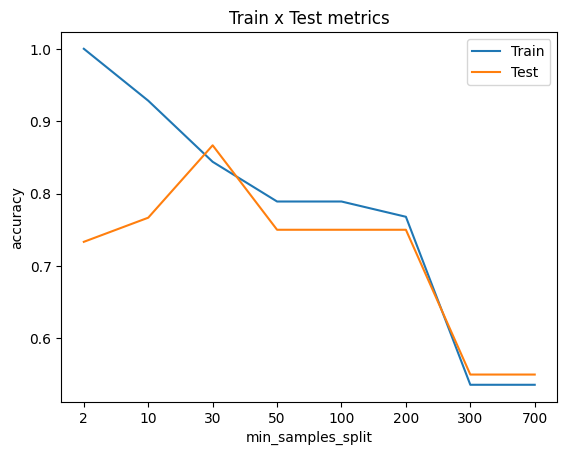

In [109]:
accuracy_list_train = []
accuracy_list_test = []
for min_samples_split in min_samples_split_list:
    
    model = DecisionTreeClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train)
    predictions_train = model.predict(X_train) 
    predictions_test = model.predict(X_test) 
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

Note how increasing the the number of `min_samples_split` decreases the overfit.

Let's do the same experiment with `max_depth`.

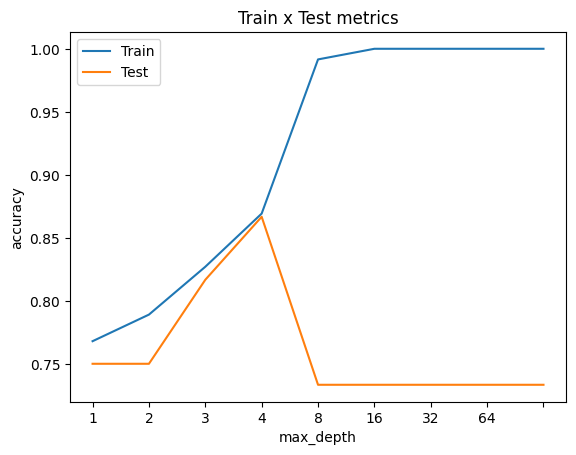

In [110]:
accuracy_list_train = []
accuracy_list_test = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train)
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

The test accuracy reaches the highest at tree_depth=3. When the allowed depth is smaller, the tree cannot make enough splits to distinguish positives from negatives (having the underfit problem), but when the allowed depth is too high ( >= 5), the tree becomes too specialized to the training set and thus losing accuracy to the test dataset (having the overfit problem). Our final tree model then will have:

- `max_depth = 3`
- `min_samples_split = 50`

In [111]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = 50,
                                             max_depth = 3,
                                             random_state = RANDOM_STATE).fit(X_train,y_train)

In [112]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_test),y_test):.4f}")

Metrics train:
	Accuracy score: 0.7890
Metrics test:
	Accuracy score: 0.7500


No sign of overfit, even though the metrics are not that good.

## 4.2 Random Forest



In [113]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]  ## If the number is an integer, then it is the actual quantity of samples,
                                             ## If it is a float, then it is the percentage of the dataset
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

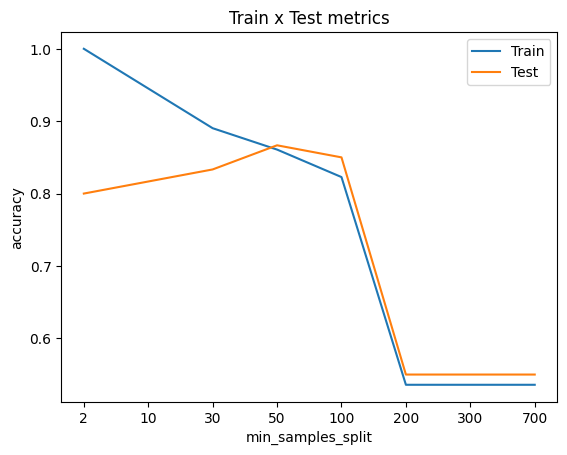

In [114]:
accuracy_list_train = []
accuracy_list_test = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train)
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

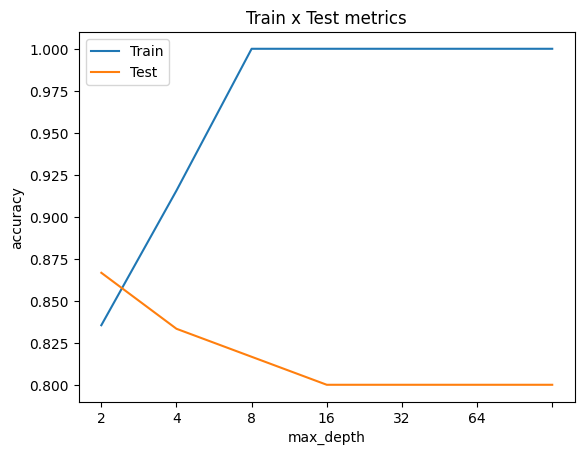

In [115]:
accuracy_list_train = []
accuracy_list_test = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train)
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

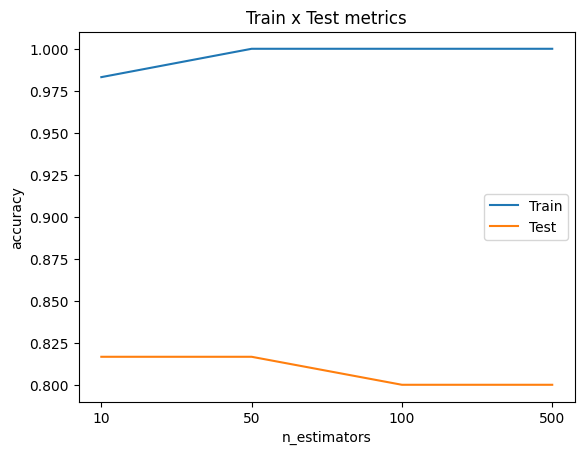

In [116]:
accuracy_list_train = []
accuracy_list_test = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = RANDOM_STATE).fit(X_train,y_train)
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_test = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_test = accuracy_score(predictions_test,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train x Test metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_test)
plt.legend(['Train','Test'])

Let's then fit a random forest with the following parameters:

 - max_depth: 8
 - min_samples_split: 10
 - n_estimators: 100

In [117]:
random_forest_model = RandomForestClassifier(n_estimators = 100,
                                             max_depth = 8,
                                             min_samples_split = 10).fit(X_train,y_train)

In [118]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_test),y_test):.4f}")

Metrics train:
	Accuracy score: 0.9620
Metrics test:
	Accuracy score: 0.8333


## 4.3 XGBoost



In [119]:
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval

In [120]:
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

You can then set a large number of estimators, because you can stop if the cost function stops decreasing.

In [121]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)], early_stopping_rounds = 50)
# Here we must pass a list to the eval_set, because you can have several different tuples ov eval sets. The parameter
# early_stopping_rounds is the number of iterations that it will wait to check if the cost function decreased or not.
# If not, it will stop and get the iteration that returned the lowest metric on the eval set.

[0]	validation_0-logloss:0.65214
[1]	validation_0-logloss:0.61601
[2]	validation_0-logloss:0.59312
[3]	validation_0-logloss:0.57407
[4]	validation_0-logloss:0.55711
[5]	validation_0-logloss:0.53623
[6]	validation_0-logloss:0.52433
[7]	validation_0-logloss:0.50688
[8]	validation_0-logloss:0.49157
[9]	validation_0-logloss:0.48280
[10]	validation_0-logloss:0.47130
[11]	validation_0-logloss:0.45879
[12]	validation_0-logloss:0.45506
[13]	validation_0-logloss:0.44485
[14]	validation_0-logloss:0.43696
[15]	validation_0-logloss:0.42572
[16]	validation_0-logloss:0.42273
[17]	validation_0-logloss:0.41678
[18]	validation_0-logloss:0.40832
[19]	validation_0-logloss:0.40377
[20]	validation_0-logloss:0.39420
[21]	validation_0-logloss:0.39449
[22]	validation_0-logloss:0.39069
[23]	validation_0-logloss:0.38823
[24]	validation_0-logloss:0.38142
[25]	validation_0-logloss:0.37660
[26]	validation_0-logloss:0.38001
[27]	validation_0-logloss:0.37848
[28]	validation_0-logloss:0.37882
[29]	validation_0-loglos

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[45]	validation_0-logloss:0.38415
[46]	validation_0-logloss:0.38589
[47]	validation_0-logloss:0.38288
[48]	validation_0-logloss:0.38718
[49]	validation_0-logloss:0.38970
[50]	validation_0-logloss:0.39033
[51]	validation_0-logloss:0.38740
[52]	validation_0-logloss:0.38773
[53]	validation_0-logloss:0.39021
[54]	validation_0-logloss:0.39188
[55]	validation_0-logloss:0.39489
[56]	validation_0-logloss:0.39305
[57]	validation_0-logloss:0.39581
[58]	validation_0-logloss:0.39095
[59]	validation_0-logloss:0.39440
[60]	validation_0-logloss:0.39570
[61]	validation_0-logloss:0.39729
[62]	validation_0-logloss:0.39656
[63]	validation_0-logloss:0.39296
[64]	validation_0-logloss:0.39608
[65]	validation_0-logloss:0.39583
[66]	validation_0-logloss:0.39379
[67]	validation_0-logloss:0.39523
[68]	validation_0-logloss:0.39327
[69]	validation_0-logloss:0.39267
[70]	validation_0-logloss:0.39142
[71]	validation_0-logloss:0.38991
[72]	validation_0-logloss:0.39349
[73]	validation_0-logloss:0.39312
[74]	validatio

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=55, ...)

As you can see, even though you passed 500 estimators to fit, the algorithm only fitted 66 because the log-loss used to metrify the training rounds started to increase. In fact, the number of estimators is even less than 66. If you take a closeer look to the metrics, you see that with 16 fitted trees, we achieved the minimum value of the log-loss, and in fact, this is the number of fitted trees in the final model:

In [122]:
xgb_model.best_iteration

34

In [123]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_test),y_test):.4f}")

Metrics train:
	Accuracy score: 0.9578
Metrics test:
	Accuracy score: 0.8000


You can see that RandomForest achieved the best accuracy, but the results overall were close. And note that we got a very close test metric with XGBoost compared to RandomForest, and we didn't even performed any hyperparameter search! The advantage of XGBoost is that it is faster than the Random Forest and also it has more parameters, therefore you are able to fine-tune the model to achieve even better results.